# Kalorona-CNN - A ResNet Implementation

This notebook aims to modify and test models.

## Preparation

### Import Libraries

In [1]:
import torch
import os
from torch import nn
import numpy as np
import cv2
from tqdm import tqdm
import time
# ResNet model
from models.ResNet import resnet50
# DALI
from nvidia.dali.pipeline import Pipeline
from nvidia.dali.plugin.pytorch import DALIClassificationIterator, LastBatchPolicy
from nvidia.dali.pipeline import pipeline_def
import nvidia.dali.types as types
import nvidia.dali.fn as fn
from ImageNetLoader import ImageNetDALIPipeline

### Hyperparameters

In [2]:
# Training Hyperparameters
learning_rate = 1e-3
momentum = 0.9
batch_size = 32
epoch_limit = 20
current_checkpoint = 0

dataset_dir = '/mnt/store/ImageNet/dataset/ILSVRC/'
img_dir = os.path.join(dataset_dir, 'Data', 'CLS-LOC')
annotation_dir = os.path.join(dataset_dir, 'Annotations', 'CLS-LOC', 'val')
training_dataset_dir = os.path.join(img_dir, 'train')
eval_dataset_dir = os.path.join(img_dir, 'eval')

save_dir = './saves/'

### Optional Utility - Rearrange Eval Folder

In [ ]:
import xml.dom.minidom

def rearrange_dataset():
    src_path = os.path.join(img_dir, 'val')
    dst_path = eval_dataset_dir
    for filename in tqdm(os.listdir(annotation_dir)):
        xml_path = os.path.join(annotation_dir, filename)
        DOMTree = xml.dom.minidom.parse(xml_path)
        anno_root = DOMTree.documentElement
        image_name = anno_root.getElementsByTagName("filename")[0].firstChild.data
        type_name = anno_root.getElementsByTagName("object")[0].getElementsByTagName("name")[0].firstChild.data
        # print(f"image_name : {image_name}, type_name : {type_name}")
        src_image_path = os.path.join(src_path, image_name + ".JPEG")
        dst_image_folder = os.path.join(dst_path, type_name)
        if not os.path.exists(dst_image_folder):
            os.mkdir(dst_image_folder)
        dst_image_path = os.path.join(dst_path, type_name, image_name + ".JPEG")
        os.rename(src_image_path, dst_image_path)

rearrange_dataset()

## Create / Load a model

### Create a new model from scratch

In [3]:
model = resnet50().cuda()
print('New model create.')

New model create.


### Load a model from disk

In [3]:
current_checkpoint = eval(input('Please input the checkpoint ID: '))
model_path = os.path.join(save_dir, f'model-ResNet-{current_checkpoint}.pth')
print(f'Loading from {model_path}...')
model = resnet50()
model.load_state_dict(torch.load(model_path))
model = model.cuda()
print('Loaded!')

Loading from ./saves/model-ResNet-5.pth...
Loaded!


## Train / Eval

### History Log

In [4]:
import json

records = {
    'epoch_reports' : [

    ],
    'eval_reports' : [

    ],
    'current_iter' : 0
}

In [5]:
def LoadHistory():
    global records
    records = json.load(open('history.json', 'r'))
def SaveHistory():
    json.dump(records, open('history.json', 'w'))

### Utility - Load records from history file

In [6]:
LoadHistory()

### Utility - Save records to history file

In [6]:
SaveHistory()

### DataLoaders & Init

In [7]:
pipe = ImageNetDALIPipeline(batch_size=batch_size,
                            num_threads=4,
                            device_id=0,
                            seed=12,
                            data_dir=os.path.join(dataset_dir, "Data", "CLS-LOC", "train"),
                            crop=224,
                            size=256,
                            shard_id=0,
                            num_shards=1,
                            is_training=True)
pipe.build()
training_dataloader = DALIClassificationIterator(pipe, reader_name="Reader", last_batch_policy=LastBatchPolicy.FILL, auto_reset=True)

pipe = ImageNetDALIPipeline(batch_size=batch_size,
                            num_threads=4,
                            device_id=0,
                            seed=12,
                            data_dir=os.path.join(dataset_dir, "Data", "CLS-LOC", "eval"),
                            crop=224,
                            size=256,
                            shard_id=0,
                            num_shards=1,
                            is_training=False)
pipe.build()
eval_dataloader = DALIClassificationIterator(pipe, reader_name="Reader", last_batch_policy=LastBatchPolicy.FILL, auto_reset=True)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

### Training & Test Loops

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer, enable_log=True):
    global current_checkpoint
    size = dataloader.size
    pgbr = tqdm(total=size)
    loss_records = []
    print(f'Epoch {current_checkpoint + 1}\n')

    iter_id = records['current_iter']
    epoch_report = {'epoch_id': current_checkpoint + 1, 'start_iter': iter_id}
    
    tic = time.clock()

    for batch, data in enumerate(dataloader):
        for d in data:
            #X, Y = X.cuda(), Y.cuda()
            X, Y = d["data"], d["label"].squeeze(-1).long()
            pred = model(X)
            loss = loss_fn(pred, Y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pgbr.update(batch_size)
            iter_id += 1
            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
                loss_records.append({'iter': iter_id, 'loss': float(loss)})

    toc = time.clock()
    
    print(f'Epoch {current_checkpoint + 1} Completed')
    torch.save(model.state_dict(), os.path.join(save_dir, f'model-ResNet-{current_checkpoint + 1}.pth'))
    current_checkpoint += 1

    epoch_report['elapse_seconds'] = toc - tic
    epoch_report['end_iter'] = iter_id
    epoch_report['iter_loss'] = loss_records
    if enable_log:
        records['current_iter'] = iter_id
        records['epoch_reports'].append(epoch_report)
        SaveHistory()
    print(f'Model & Record file saved. Elapsed Time: {toc - tic}')

def test_loop(dataloader, model, loss_fn, enable_log=True):
    global current_checkpoint
    size = dataloader.size
    num_batches = 0
    test_loss, correct = 0, 0
    pgbr = tqdm(size)

    with torch.no_grad():
        for batch, data in enumerate(dataloader):
            for d in data:
                X, y = d["data"], d["label"].squeeze(-1).long()
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                num_batches += 1
                pgbr.update(batch_size)

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if enable_log:
        eval_report = {'eval_checkpoint': current_checkpoint, 'avg_loss': float(test_loss), 'accuracy': float(100 * correct), 'time': time.asctime()}
        records['eval_reports'].append(eval_report)
        SaveHistory()
        print('Eval report saved, history file saved.')

## Operate

### Train the model

In [ ]:
while current_checkpoint < epoch_limit:
    train_loop(training_dataloader, model, loss_fn, optimizer)
    test_loop(eval_dataloader, model, loss_fn)
    training_dataloader.reset()
    eval_dataloader.reset()

  0%|                                                                                                                          | 0/1281167 [00:00<?, ?it/s]/home/kalorona/anaconda3/envs/DL/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


Epoch 1



  0%|                                                                                                               | 64/1281167 [00:01<5:25:50, 65.53it/s]

loss: 7.222864 [    0/1281167]


  0%|▎                                                                                                           | 3136/1281167 [00:26<2:59:33, 118.62it/s]

### Evaluate the model

In [12]:
test_loop(eval_dataloader, model, loss_fn, False)
# test_loop(eval_dataloader, model, loss_fn)

50000it [04:35, 181.61it/s]

Test Error: 
 Accuracy: 3.6%, Avg loss: 7.069505 

Eval report saved, history file saved.


## Make Graphs

In [10]:
import matplotlib.pyplot as plt

### Loss Graph

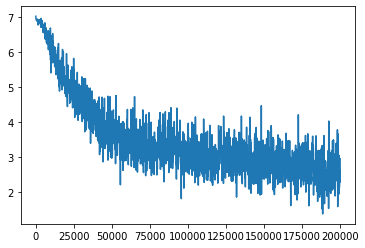

In [11]:
def DrawLossGraph():
    epoch_reports = records['epoch_reports']
    xpts, ypts = [], []
    for report in epoch_reports:
        for loss_rec in report['iter_loss']:
            xpts.append(loss_rec['iter']), ypts.append(loss_rec['loss'])
    plt.plot(np.array(xpts), np.array(ypts))
    plt.show()

DrawLossGraph()

### Accuracy Graph

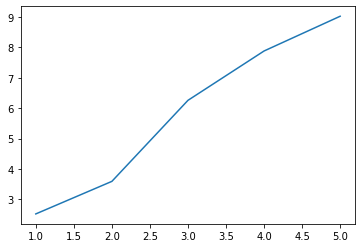

In [12]:
def DrawAccuracyGraph():
    eval_reports = records['eval_reports']
    xpts, ypts = [], []
    for report in eval_reports:
        xpts.append(report['eval_checkpoint']), ypts.append(report['accuracy'])
    plt.plot(np.array(xpts), np.array(ypts))
    plt.show()

DrawAccuracyGraph()